✅ Gold Retail gespeichert unter: s3://batch-bucket/gold/retail/retail_aggregated.parquet


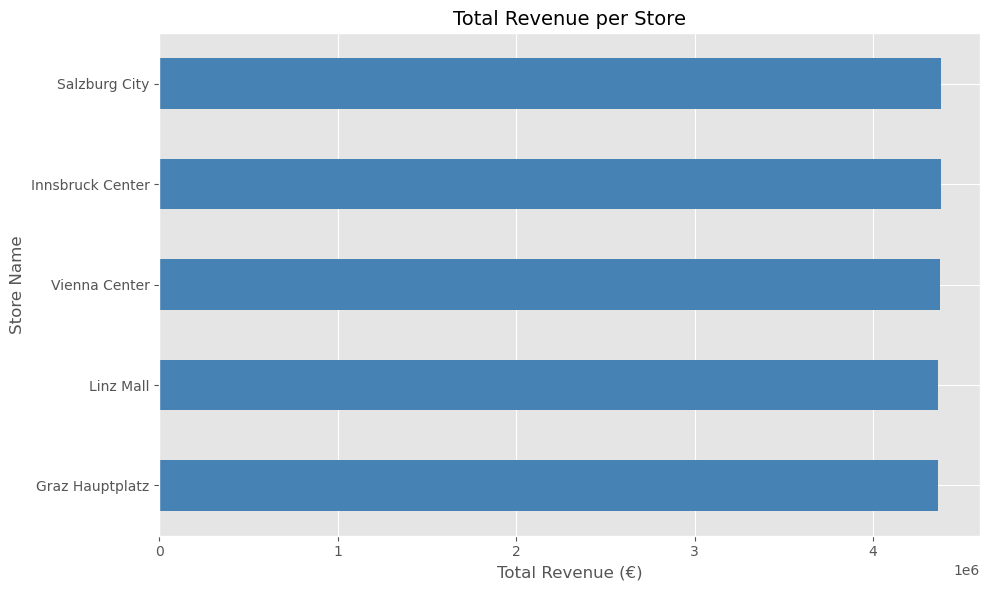

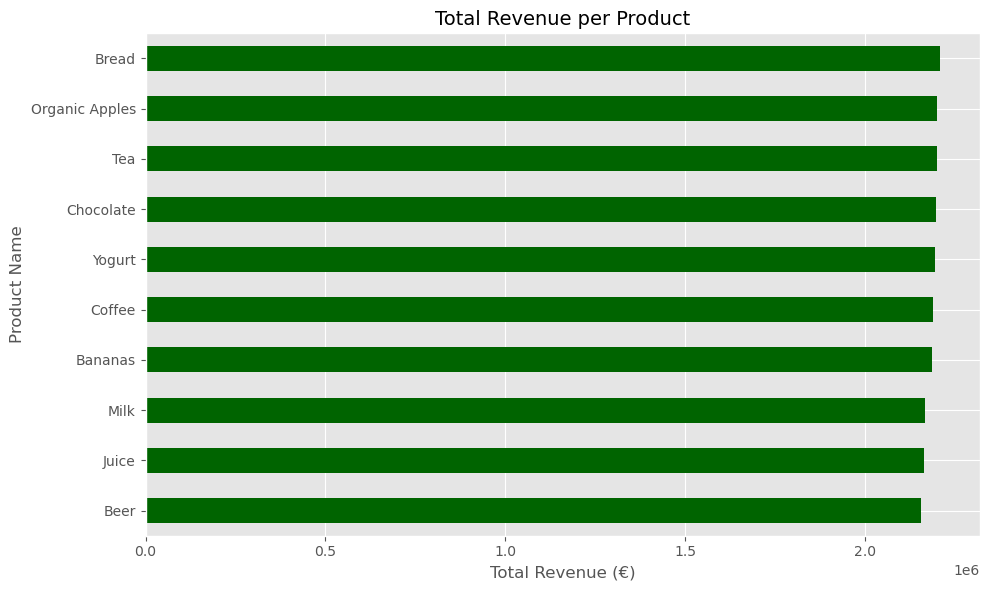

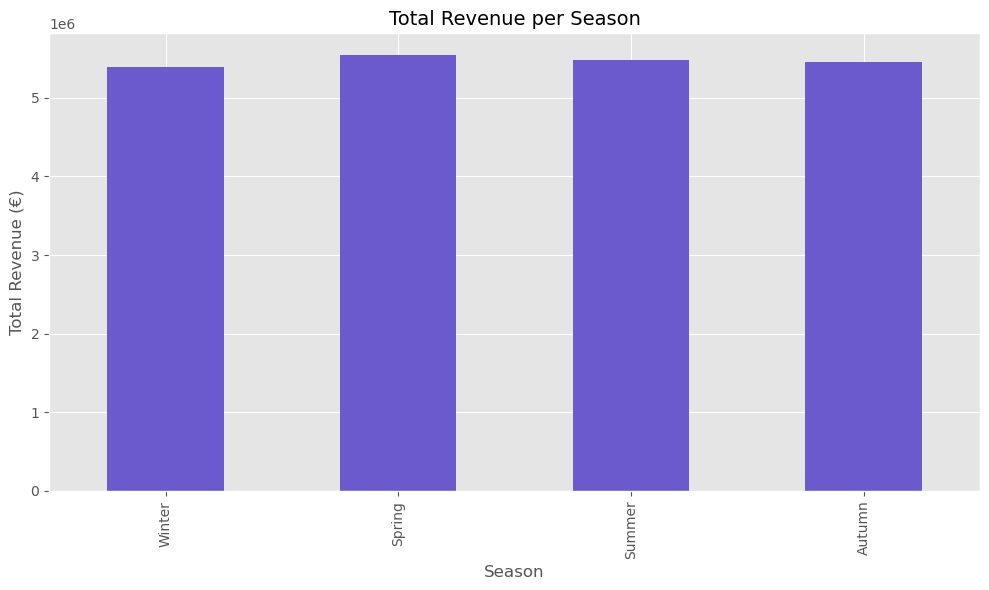

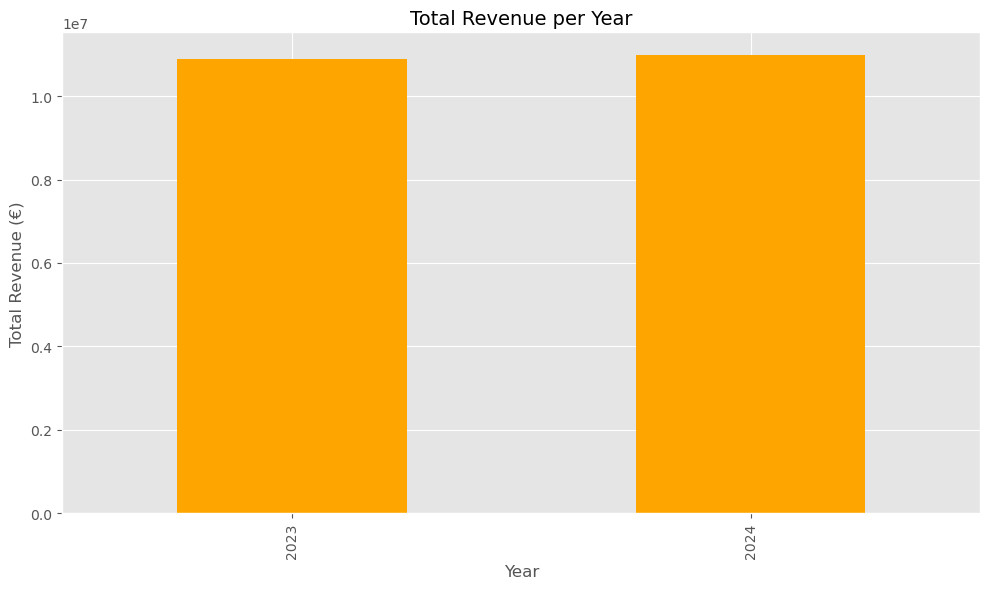

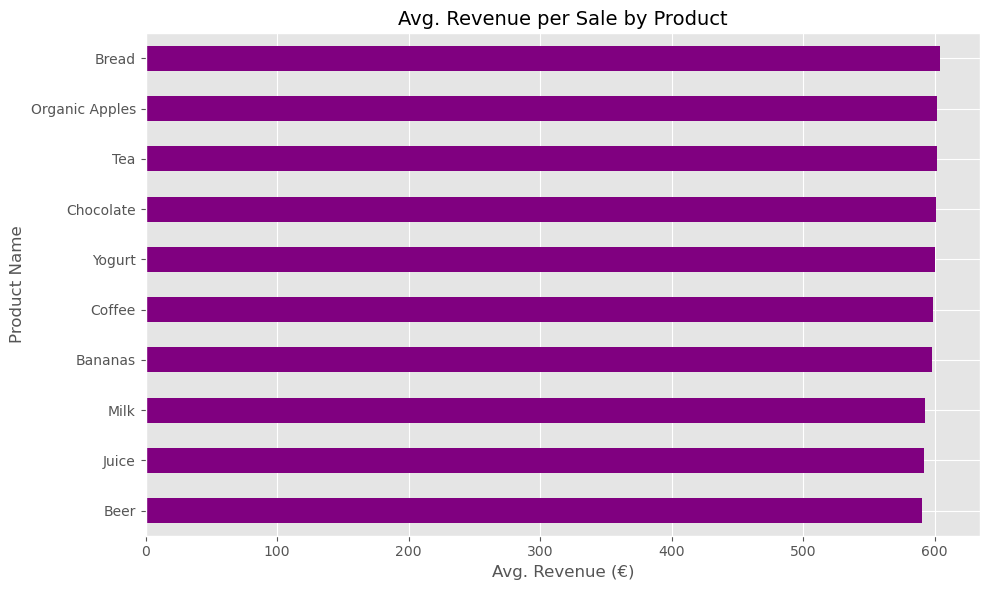

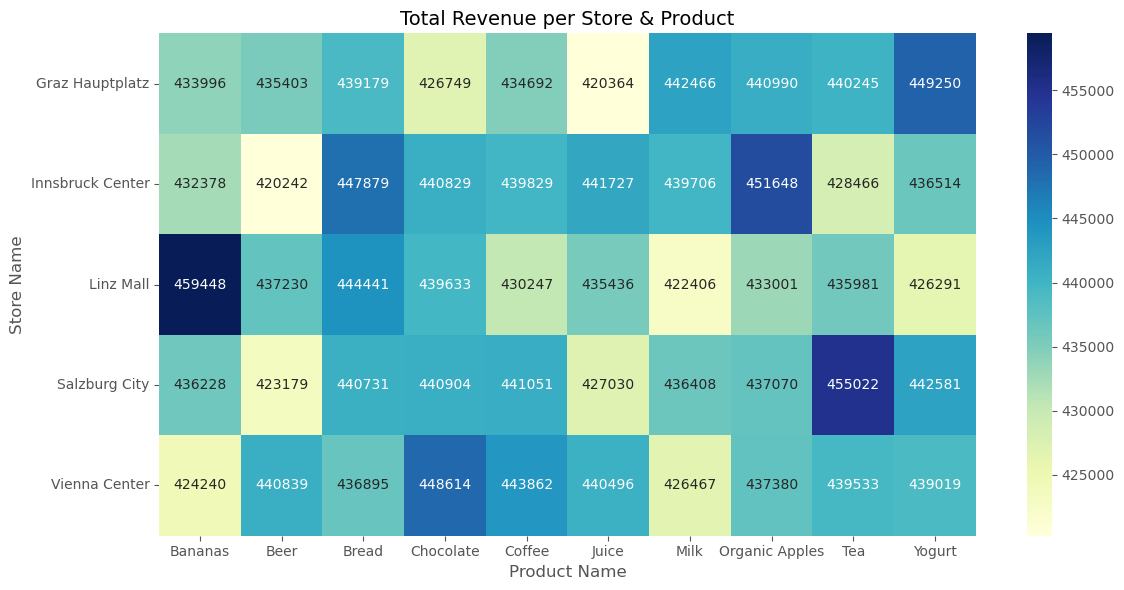

In [4]:
import duckdb
import boto3
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------- MinIO Config --------------------------------
MINIO_ENDPOINT   = "http://minio:9000"
MINIO_ACCESS_KEY = "admin"
MINIO_SECRET_KEY = "password"
BUCKET_NAME      = "batch-bucket"
SILVER_FILE_NAME = "silver/retail/retail_cleaned.parquet"
GOLD_FILE_NAME   = "gold/retail/retail_aggregated.parquet"

# ----------------------------- MinIO Client --------------------------------
s3 = boto3.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    aws_access_key_id=MINIO_ACCESS_KEY,
    aws_secret_access_key=MINIO_SECRET_KEY
)

# ----------------------------- Load Silver Retail --------------------------
silver_obj = s3.get_object(Bucket=BUCKET_NAME, Key=SILVER_FILE_NAME)
df_silver = pd.read_parquet(BytesIO(silver_obj["Body"].read()))

# ----------------------------- Aggregation ---------------------------------
conn = duckdb.connect(database=":memory:")
conn.register("retail_data", df_silver)

df_aggregated = conn.execute("""
    SELECT 
        store_name,
        product_name,
        season,
        year,
        SUM(revenue) AS total_revenue,
        AVG(revenue) AS avg_revenue,
        COUNT(*) AS num_sales
    FROM retail_data
    GROUP BY store_name, product_name, season, year
    ORDER BY store_name, product_name, season, year
""").fetchdf()

# ----------------------------- Save Gold -----------------------------------
buffer = BytesIO()
df_aggregated.to_parquet(buffer, engine="pyarrow", index=False)
buffer.seek(0)

s3.put_object(Bucket=BUCKET_NAME, Key=GOLD_FILE_NAME, Body=buffer.read())
print(f"✅ Gold Retail gespeichert unter: s3://{BUCKET_NAME}/{GOLD_FILE_NAME}")

# ----------------------------- Visualisierung ------------------------------
plt.style.use("ggplot")
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": (10, 6)
})

# Umsatz pro Store
store_revenue = df_aggregated.groupby("store_name")["total_revenue"].sum().sort_values()
store_revenue.plot(kind="barh", title="Total Revenue per Store", color="steelblue")
plt.xlabel("Total Revenue (€)")
plt.ylabel("Store Name")
plt.tight_layout()
plt.show()

# Umsatz pro Produkt
product_revenue = df_aggregated.groupby("product_name")["total_revenue"].sum().sort_values()
product_revenue.plot(kind="barh", title="Total Revenue per Product", color="darkgreen")
plt.xlabel("Total Revenue (€)")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()

# Umsatz nach Saison
season_order = ["Winter", "Spring", "Summer", "Autumn"]
season_revenue = df_aggregated.groupby("season")["total_revenue"].sum().reindex(season_order)
season_revenue.plot(kind="bar", title="Total Revenue per Season", color="slateblue")
plt.ylabel("Total Revenue (€)")
plt.xlabel("Season")
plt.tight_layout()
plt.show()

# Umsatz pro Jahr
year_revenue = df_aggregated.groupby("year")["total_revenue"].sum()
year_revenue.plot(kind="bar", title="Total Revenue per Year", color="orange")
plt.ylabel("Total Revenue (€)")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# Durchschnittlicher Umsatz pro Produkt
avg_rev_per_product = df_aggregated.groupby("product_name")["avg_revenue"].mean().sort_values()
avg_rev_per_product.plot(kind="barh", title="Avg. Revenue per Sale by Product", color="purple")
plt.xlabel("Avg. Revenue (€)")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()

# Heatmap: Store vs. Product Umsatz
pivot = df_aggregated.pivot_table(index="store_name", columns="product_name", values="total_revenue", aggfunc="sum")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Total Revenue per Store & Product")
plt.xlabel("Product Name")
plt.ylabel("Store Name")
plt.tight_layout()
plt.show()



🔍 Gesamtkorrelation von Wetter & Umsatz:
             temperature  humidity  wind_speed   revenue
temperature     1.000000  0.032796    0.060292  0.004628
humidity        0.032796  1.000000   -0.034375 -0.005690
wind_speed      0.060292 -0.034375    1.000000 -0.005450
revenue         0.004628 -0.005690   -0.005450  1.000000

📈 Korrelation Temperatur ↔ Umsatz pro Produkt:
   Organic Apples       ➜ r = -0.00
   Bananas              ➜ r = 0.02
   Bread                ➜ r = -0.00
   Milk                 ➜ r = 0.02
   Beer                 ➜ r = -0.03
   Juice                ➜ r = 0.03
   Yogurt               ➜ r = 0.02
   Chocolate            ➜ r = -0.00
   Coffee               ➜ r = -0.01
   Tea                  ➜ r = -0.00


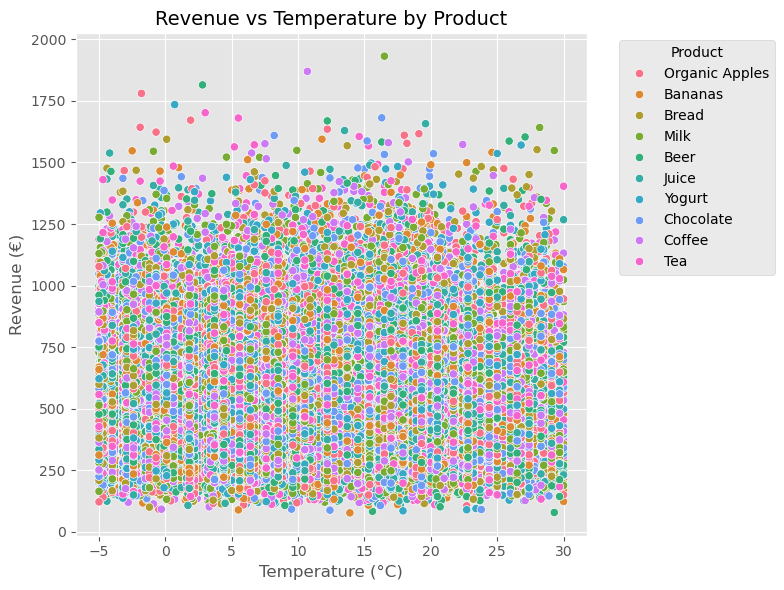

✅ Kombinierter Retail+Weather-Gold gespeichert unter: s3://batch-bucket/gold/retail_weather/retail_weather_combined.parquet


In [6]:
import duckdb
import boto3
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------- MinIO Config --------------------------------
MINIO_ENDPOINT = "http://minio:9000"
MINIO_ACCESS_KEY = "admin"
MINIO_SECRET_KEY = "password"
BUCKET_NAME = "batch-bucket"
RETAIL_SILVER = "silver/retail/retail_cleaned.parquet"
WEATHER_SILVER = "silver/weather/weather_cleaned.parquet"
GOLD_FILE_NAME = "gold/retail_weather/retail_weather_combined.parquet"

# ----------------------------- MinIO Client --------------------------------
s3 = boto3.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    aws_access_key_id=MINIO_ACCESS_KEY,
    aws_secret_access_key=MINIO_SECRET_KEY
)

# ----------------------------- Load Silver Data ----------------------------
retail_obj = s3.get_object(Bucket=BUCKET_NAME, Key=RETAIL_SILVER)
df_retail = pd.read_parquet(BytesIO(retail_obj["Body"].read()))

weather_obj = s3.get_object(Bucket=BUCKET_NAME, Key=WEATHER_SILVER)
df_weather = pd.read_parquet(BytesIO(weather_obj["Body"].read()))

# ----------------------------- Join by Date --------------------------------
# Ensure datetime format and join on "date"
df_retail["date"] = pd.to_datetime(df_retail["date"])
df_weather["date"] = pd.to_datetime(df_weather["date"])

# Merge: One-to-many join, assuming weather per day is unique
df_merged = pd.merge(df_retail, df_weather, on="date", how="inner")

# ----------------------------- Correlation ---------------------------------
print("\n🔍 Gesamtkorrelation von Wetter & Umsatz:")
print(df_merged[["temperature", "humidity", "wind_speed", "revenue"]].corr())

# ---------------------- Produktbezogene Korrelation ------------------------
print("\n📈 Korrelation Temperatur ↔ Umsatz pro Produkt:")
products = df_merged["product_name"].unique()
for product in products:
    sub = df_merged[df_merged["product_name"] == product]
    corr = sub["temperature"].corr(sub["revenue"])
    print(f"   {product:20s} ➜ r = {corr:.2f}")

# ----------------------------- Scatterplot ---------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_merged, x="temperature", y="revenue", hue="product_name")
plt.title("Revenue vs Temperature by Product")
plt.xlabel("Temperature (°C)")
plt.ylabel("Revenue (€)")
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ----------------------------- Save to Gold Layer --------------------------
buffer = BytesIO()
df_merged.to_parquet(buffer, engine="pyarrow", index=False)
buffer.seek(0)

s3.put_object(Bucket=BUCKET_NAME, Key=GOLD_FILE_NAME, Body=buffer.read())
print(f"✅ Kombinierter Retail+Weather-Gold gespeichert unter: s3://{BUCKET_NAME}/{GOLD_FILE_NAME}")


✅ Wetter-Aggregationen gespeichert unter: s3://batch-bucket/gold/weather/weather_aggregated.parquet


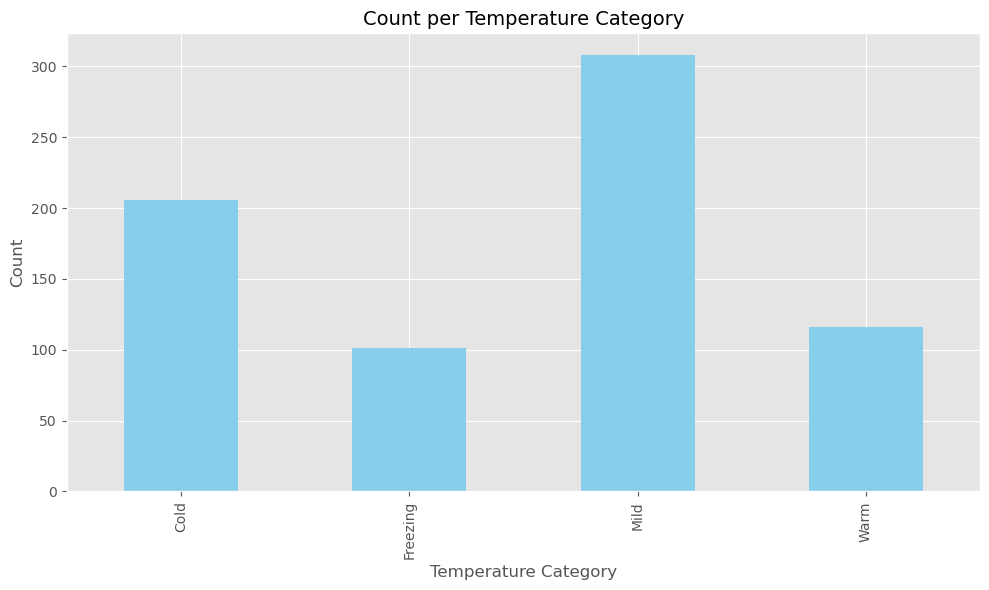

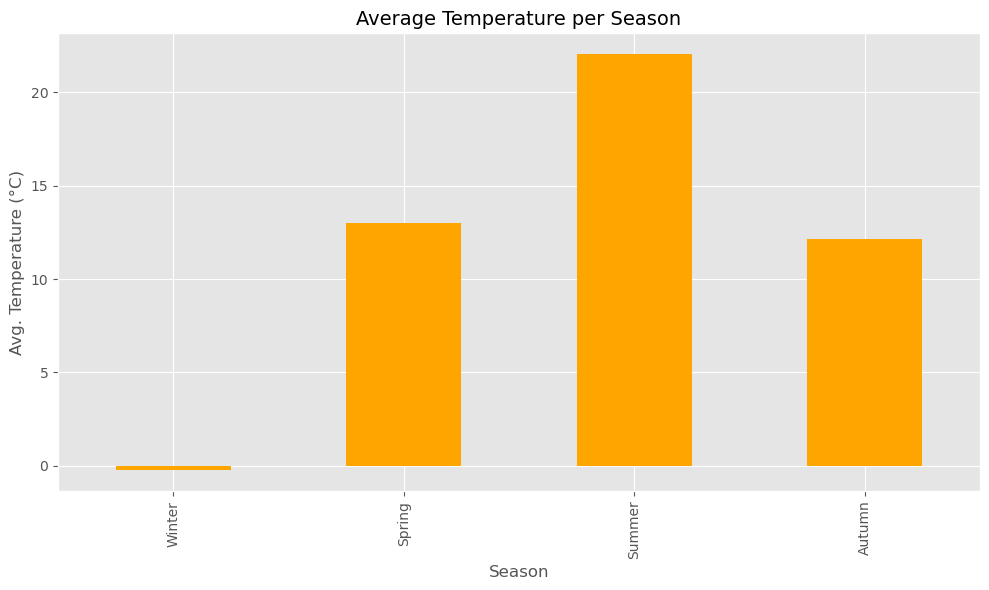

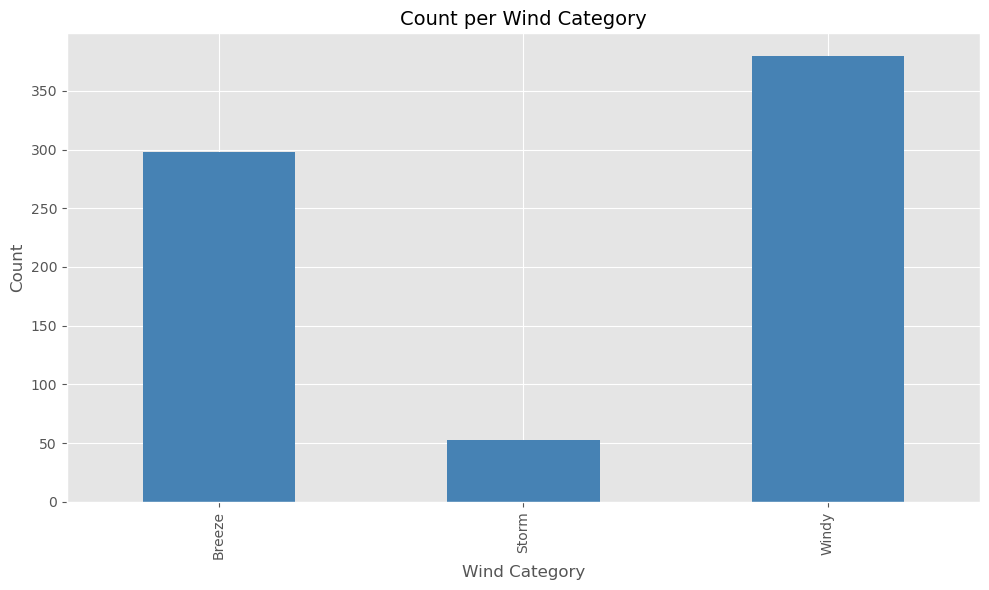

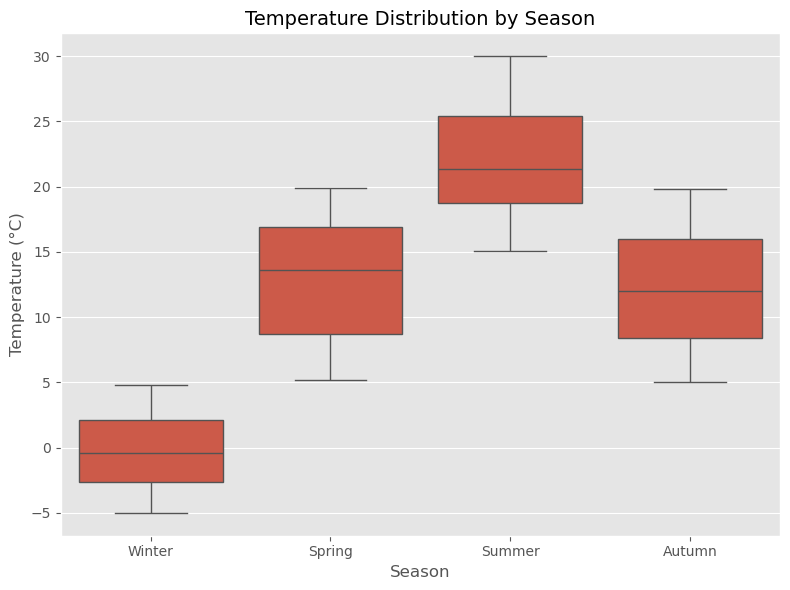

In [7]:
import duckdb
import boto3
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------- MinIO Config --------------------------------
MINIO_ENDPOINT = "http://minio:9000"
MINIO_ACCESS_KEY = "admin"
MINIO_SECRET_KEY = "password"
BUCKET_NAME = "batch-bucket"
SILVER_KEY = "silver/weather/weather_cleaned.parquet"
GOLD_KEY = "gold/weather/weather_aggregated.parquet"

# ----------------------------- MinIO Client --------------------------------
s3 = boto3.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    aws_access_key_id=MINIO_ACCESS_KEY,
    aws_secret_access_key=MINIO_SECRET_KEY
)

# ----------------------------- Load Silver Weather -------------------------
obj = s3.get_object(Bucket=BUCKET_NAME, Key=SILVER_KEY)
df_weather = pd.read_parquet(BytesIO(obj["Body"].read()))

# ----------------------------- Aggregation via DuckDB ----------------------
conn = duckdb.connect(database=":memory:")
conn.register("weather_data", df_weather)

df_aggregated = conn.execute("""
    SELECT
        season,
        temperature_category,
        COUNT(*) AS count,
        AVG(temperature) AS avg_temp,
        AVG(humidity) AS avg_humidity,
        AVG(wind_speed) AS avg_wind_speed
    FROM weather_data
    GROUP BY season, temperature_category
    ORDER BY season, temperature_category
""").fetchdf()

# ----------------------------- Save Gold Aggregated ------------------------
buffer = BytesIO()
df_aggregated.to_parquet(buffer, engine="pyarrow", index=False)
buffer.seek(0)

s3.put_object(Bucket=BUCKET_NAME, Key=GOLD_KEY, Body=buffer.read())
print(f"✅ Wetter-Aggregationen gespeichert unter: s3://{BUCKET_NAME}/{GOLD_KEY}")

# ----------------------------- Visualisierungen ----------------------------
plt.style.use("ggplot")
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": (10, 6)
})

# 📊 Anzahl Messungen pro Temperaturkategorie
temp_counts = df_weather["temperature_category"].value_counts().sort_index()
temp_counts.plot(kind="bar", title="Count per Temperature Category", color="skyblue")
plt.xlabel("Temperature Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 📊 Durchschnittstemperatur pro Saison
season_avg_temp = df_weather.groupby("season")["temperature"].mean().reindex(["Winter", "Spring", "Summer", "Autumn"])
season_avg_temp.plot(kind="bar", title="Average Temperature per Season", color="orange")
plt.xlabel("Season")
plt.ylabel("Avg. Temperature (°C)")
plt.tight_layout()
plt.show()

# 📊 Windstärke pro Windkategorie
wind_counts = df_weather["wind_category"].value_counts().sort_index()
wind_counts.plot(kind="bar", title="Count per Wind Category", color="steelblue")
plt.xlabel("Wind Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 📊 Boxplot: Temperatur pro Saison
plt.figure(figsize=(8,6))
sns.boxplot(data=df_weather, x="season", y="temperature", order=["Winter", "Spring", "Summer", "Autumn"])
plt.title("Temperature Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.show()
